In [1]:
from datasets import Dataset, ClassLabel
import pandas as pd
import numpy as np
import os

from toolkit.adriano.classification import *
from toolkit.adriano_v0.modeling.datamodule import DataModule ## TODO: review this and move to main
from toolkit.adriano_v0.modeling.splitter import RandomSplitter ## TODO: review this and move to main
from toolkit.adriano.modeling.sampler import UnderSample
from toolkit.adriano.image.open import open_img_as_tensor

In [2]:
DATASET_PATH = '/mnt/c/Users/adria/Downloads/kaggle-mayo'

In [3]:
ds = Dataset.from_csv(DATASET_PATH + '/train.csv')
ds

Using custom data configuration default-3f1752025948278b
Reusing dataset csv (/home/adria/.cache/huggingface/datasets/csv/default-3f1752025948278b/0.0.0)


Dataset({
    features: ['image_id', 'center_id', 'patient_id', 'image_num', 'label'],
    num_rows: 754
})

In [4]:
ds[0]

{'image_id': '006388_0',
 'center_id': 11,
 'patient_id': '006388',
 'image_num': 0,
 'label': 'CE'}

In [5]:
label_encoder = ClassLabel(names = ['CE', 'LAA'])

In [6]:
def mayo_type_tfm(example):
    img_id = example['image_id']
    imgs = [open_img_as_tensor(f"{DATASET_PATH}/train/{img_id}_{i}.jpg") for i in range(16)]
    example[Keys.input] = torch.stack(imgs)
    example[Keys.target] = torch.tensor(label_encoder.str2int(example['label']))
    return example

In [7]:
dblock = BaseDataBlock(
    type_tfm=[mayo_type_tfm]
)
splitter = RandomSplitter(seed=42) # replace this with a proper splitter after an EDA
resampler = UnderSample('label')

ds_train, ds_test = splitter(ds)
ds_valid = UnderSample('label').sample(ds_test)

dm = DataModule(
    (ds_train, ds_valid, ds_test), dblock, None, resampler,
    num_workers=10, prefetch_factor=2, batch_size=2,
    shuffle=False, drop_last=False,
    train__shuffle=True, train__drop_last=True,
    )
print("Creating train dataloader for debugging ...")
dm.setup()
dl_train = dm.train_dataloader()

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Undersampling... original dataset had 151 examples, new ones will have 74 (2 x 37)
Creating train dataloader for debugging ...


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Undersampling... original dataset had 603 examples, new ones will have 340 (2 x 170)


In [8]:
batch_tfm_train = K.VideoSequential(
    K.ColorJiggle(0.1, 0.2, 0.1, 0, p=0.5),
    K.RandomAffine(2, (0.1, 0.1), (0.95, 1.05), (0.05, 0.05), p=0.5),
)
batch_tfm_test = None
print('='*50)
print('Shapes of tensors in train_batch:')
batch = next(iter(dl_train))
batch[Keys.input] = batch_tfm_train(batch[Keys.input])
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(f"{k} -> {v.shape}")
print('='*50)

Shapes of tensors in train_batch:
input -> torch.Size([2, 16, 3, 1024, 1024])
target -> torch.Size([2])


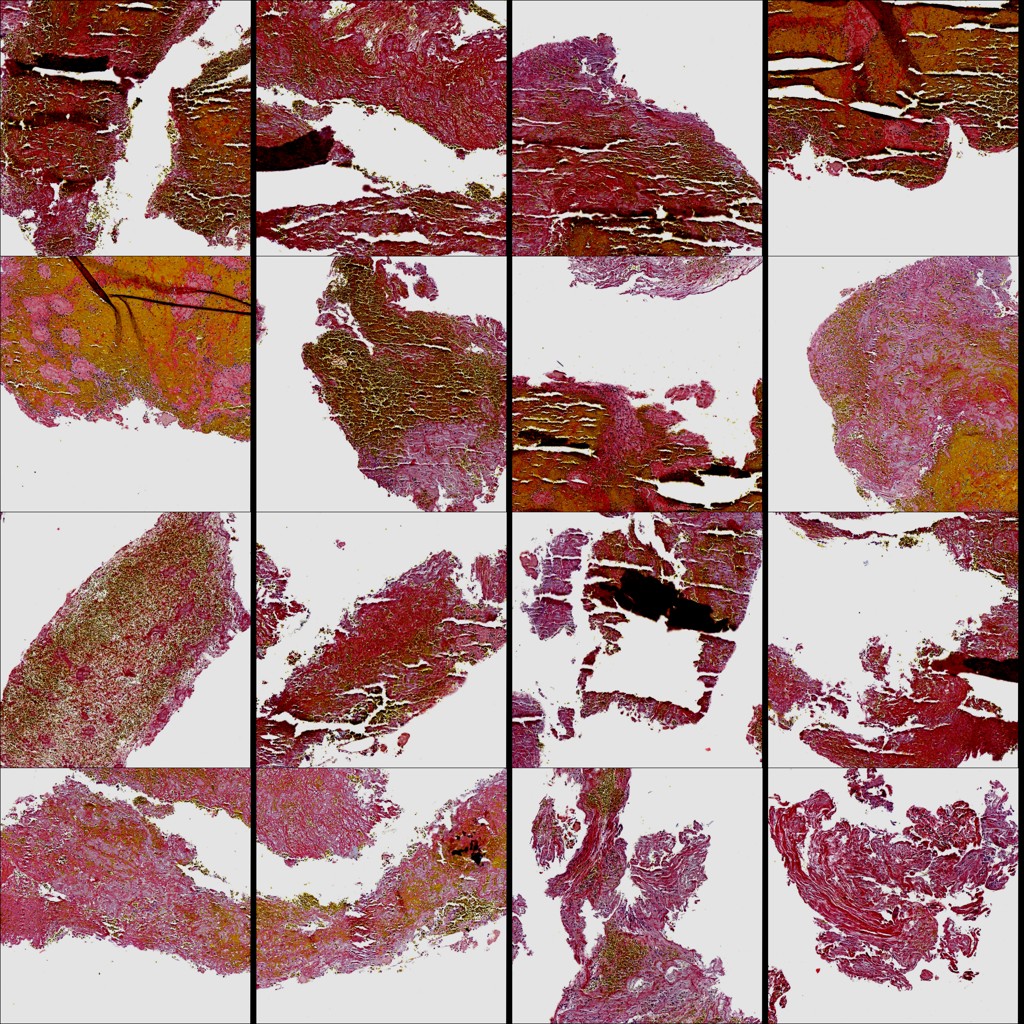

In [9]:
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

(ToPILImage()(make_grid(batch['input'][0], nrow=4))).resize((1024,1024))

In [10]:
nn.Flatten(0, 1)(batch['input']).shape

torch.Size([32, 3, 1024, 1024])

In [31]:
class MayoNeck(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n
        self.pool = nn.AdaptiveMaxPool1d(1)
    def forward(self, x):
        x = x.view(-1, self.n, x.shape[-1])
        x = self.pool(x.swapaxes(1, 2)).squeeze(-1)
        return x

In [34]:
preprocessor = module_dict_wraper(nn.Flatten(0, 1), input_key=Keys.input, output_key=Keys.input)
neck = module_dict_wraper(MayoNeck(16), input_key=Keys.embeddings, output_key=Keys.features)
head = module_dict_wraper(LinearHead(2), input_key=Keys.features, output_key=Keys.logits)
loss = module_dict_wraper(nn.CrossEntropyLoss(), input_key=[Keys.logits, Keys.target], output_key=Keys.loss)
model = BaseModel(
    preprocessor=preprocessor,
    backbone='resnet18',
    neck=neck,
    head=head,
    loss=loss,
    input_shape=(2, 16, 3, 1024, 1024),
)

Initializing all lazy layers with `input_shape`... make sure it is accurate!


In [38]:
with torch.no_grad():
    outputs = model.shared_step(batch)

print('='*50)
print('Checking model output shapes:')
for k, v in outputs.items():
    if 'loss' in k:
        print(k, '->', v.item())
    else:
        print(k, '->', v.shape)

Checking model output shapes:
input -> torch.Size([32, 3, 1024, 1024])
embeddings -> torch.Size([32, 512])
features -> torch.Size([2, 512])
logits -> torch.Size([2, 2])
loss -> 0.9309439063072205
